In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.metrics import mean_squared_error

In [2]:
def rand(N):
    results = []
    
    for i in range(N):
        temp = np.random.rand()
        if temp < 0.5:
            results.append(np.random.rand())
        else:
            results.append(-np.random.rand())
        
    return np.array(results)

### System Model

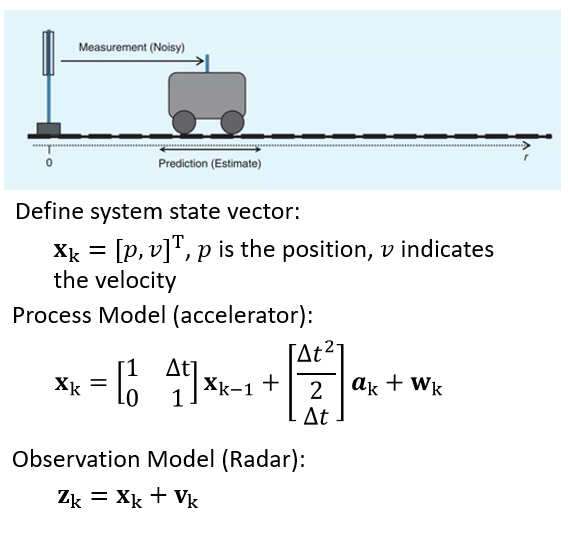

In [3]:
Image(filename='model.PNG') 

### Truth Data Generation

In [4]:
N = 100  # Total sampling points
dt = 0.1 # Sampling interval, units: s

#acc subject to N(mu,sigma^2) Gaussian distribution
acc_mu = 0
acc_sigma = 0.05
acc_true = acc_mu + acc_sigma*rand(N)

#truth velocity and position
vec_truth = []
vec_instant = 0
pos_truth = []
pos_instant = 0
for i in range(N):
    pos_instant += vec_instant*dt + 0.5*acc_true[i]*dt**2
    pos_truth.append(pos_instant)
    vec_instant += acc_true[i]*dt
    vec_truth.append(vec_instant)

### Observed acceleration by the accelerometer

In [5]:
acc_noise = 0.006 # sensor Gaussian noise
acc_bias = 0.001 #sensor bias
acc_observed = acc_true + acc_bias + acc_noise*rand(N)

#calculation velocity and position by accelerometer only
pos_acc = []
pos_inst = 0
vec_acc = []
vec_inst = 0
for i in range(N):
    pos_inst += vec_inst*dt + 0.5*acc_observed[i]*dt**2
    vec_inst += acc_observed[i]*dt
    vec_acc.append(vec_inst)
    pos_acc.append(pos_inst)

### Measured veclocity and position by Radar directly 

In [6]:
vec_noise = 0.004 # radar noise when measuring velocity
vec_measured = vec_truth + vec_noise*rand(N)
pos_noise = 0.005
pos_measured = pos_truth + pos_noise*rand(N)

### Kalman filterring

In [7]:
x_k = np.array([[0], [0]])#state at time k
x_kk_1 = np.array([[0], [0]]) # prediction at time k based on the estimated x at k-1
x_k_1 = np.array([[0], [0]])#state at time k-1
F_k = np.array([[1, dt],[0, 1]])
B_k = np.array([[0.5*dt**2],[dt]])
Q_k = np.array([[dt**4*0.25*acc_noise**2, 0],[0, dt**2*acc_noise**2]])

H_k = np.array([[1, 0],[0, 1]])
# R_k = np.array([[vec_noise**2*dt**2, 0],[0, vec_noise**2]])
R_k = np.array([[pos_noise**2, 0],[0, vec_noise**2]])
P_k_1 = np.array([[0.1, 0],[0, 0.1]])
P_kk_1 = np.array([[0, 0],[0, 0]])
P_k = np.array([[0, 0],[0, 0]])

pos_est = [] #estimated pos by Kalman filter
vec_est = [] #estimated velocity by Kalman filter

for i in range(N):
    #predict step
    x_kk_1 = np.dot(F_k,x_k_1) + B_k*acc_observed[i]
    P_kk_1 = np.dot(np.dot(F_k, P_k_1), np.transpose(F_k)) + Q_k
    #observed measurement
    z_k = np.array([[pos_measured[i]],[vec_measured[i]]])
    #correct step
    K_k = np.dot(np.dot(P_kk_1, np.transpose(H_k)), np.linalg.inv(np.dot(np.dot(H_k, P_kk_1), np.transpose(H_k)) + R_k))
    x_k = x_kk_1 + np.dot(K_k, z_k - np.dot(H_k, x_kk_1))
    P_k = np.dot(np.identity(2) - np.dot(K_k, H_k), P_kk_1)
    #prepare for nex iteration
    x_k_1 = x_k
    P_k_1 = P_k
    #save results
    pos_est.append(x_k[0])
    vec_est.append(x_k[1])

### RMSE Calculations

In [8]:
vec_truth = np.array(vec_truth)
vec_acc = np.array(vec_acc)
vec_measured = np.array(vec_measured)
vec_est = np.array(vec_est) 
rmse_vec_accelerometer = math.sqrt(mean_squared_error(vec_truth, vec_acc))
rmse_vec_radar = math.sqrt(mean_squared_error(vec_truth, vec_measured))
rmse_vec_kalman = math.sqrt(mean_squared_error(vec_truth, vec_est))

print('RMSE for Velocity')
print('Accelerometer: ', rmse_vec_accelerometer)
print('Radar: ', rmse_vec_radar)
print('Kalman: ', rmse_vec_kalman)

pos_truth = np.array(pos_truth)
pos_acc = np.array(pos_acc)
pos_measured = np.array(pos_measured)
pos_est = np.array(pos_est)
rmse_pos_accelerometer = math.sqrt(mean_squared_error(pos_truth, pos_acc))
rmse_pos_radar = math.sqrt(mean_squared_error(pos_truth, pos_measured))
rmse_pos_kalman =  math.sqrt(mean_squared_error(pos_truth, pos_est))
print('RMSE for Position')
print('Accelerometer: ', rmse_pos_accelerometer)
print('Radar: ', rmse_pos_radar)
print('Kalman: ', rmse_pos_kalman)


RMSE for Velocity
Accelerometer:  0.00918806098719205
Radar:  0.002374013801155333
Kalman:  0.0009885833716409352
RMSE for Position
Accelerometer:  0.03662830750894204
Radar:  0.002865198426007475
Kalman:  0.0008643334783727775


### Plot results

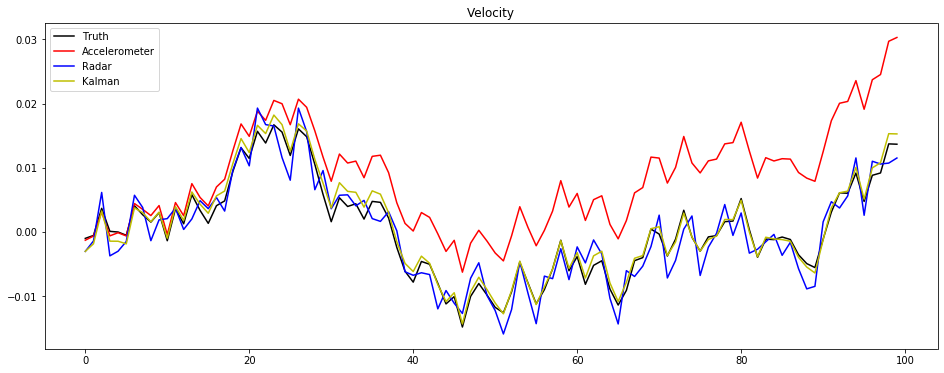

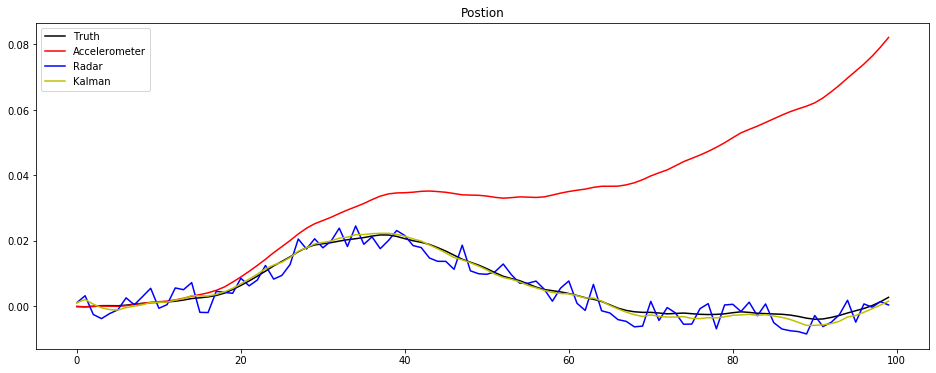

In [9]:
fig_size=(16,6)
xi = list(range(N))

fig = plt.figure(figsize=fig_size)
plt.plot(xi,vec_truth, c='k')
plt.plot(xi,vec_acc, c='r')
plt.plot(xi,vec_measured, c='b')
plt.plot(xi,vec_est, c='y')
plt.legend(['Truth','Accelerometer','Radar','Kalman'])
plt.title('Velocity')

fig = plt.figure(figsize=fig_size)
plt.plot(xi,pos_truth, c='k')
plt.plot(xi,pos_acc, c='r')
plt.plot(xi,pos_measured, c='b')
plt.plot(xi,pos_est, c='y')
plt.legend(['Truth','Accelerometer','Radar','Kalman'])
plt.title('Postion')
plt.show()